# Data Sufficiency and Selection

This notebook will be focused on the following topics:

- Why Feature Selection
- Techniques for Feature Selection
- Learning Curves

In [1]:
# all imports at the top!
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, f_classif
from sklearn.feature_selection import SelectFromModel
from IPython.display import Image

from utils import (
    train_and_test, # function
    train_and_test_logit, # function
    produce_test_predictions, # function
    encode_categoricals, # function
    categoricals, # array of categorical feature names,
    read_and_get_dummies, # read the titanic dataframe and create dummies
    plot_learning_curve, # taken from sklearn website
)

% matplotlib inline

# Motivation

## Why oh why?

Okay say that your big bossman gives you a dataset and tells you he needs some analysis
and a predictive model.

"Yes sir!" you say, "I'll throw all of the features and data we have into a notebook, createa model, call `fit()` 
and then we'll be good to deploy!"

## Is this really a good idea?

No, this is not a good idea! Why you ask? Among other reasons:

1. Lack of interpretability
1. Unexpected behavior
1. Overfitting (poor future performance)
1. Training and prediction times

It will take some time to gain a nuanced understanding of this but for now, you should place them carefully in
your memory banks and bring them to the forefront when making some of your more critical decisions around model
training.

# Let's get started by looking at the data

You all know the drill.

In [2]:
df = pd.read_csv('data/titanic.csv')
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

# From here on out

We're going to use a few functions that were written just for this learning unit and they are:

`train_and_test` - this function will do the following regular workflow for creating a classifier:

1. Read the dataset
1. Fill in nulls whereever they exist with a default value
1. Create dummies from any categorical feature
1. Create a training and test set
1. Create a classifier (`random_state=1` always) and train it
1. Train that classifier on the train set
1. Test the classifier on the test set
1. Return the classifier and the training set (both the dummy version and before-dummy version)

The other main function we will be using is 

`produce_test_predictions` - this produces predictions on the kaggle titanic test set that can be uploaded as a competition submission. Most of the work here is about making sure that the X_test is preprocessed the same way as the training set.

Don't worry yourself too much about the internals of these functions for now. They are tucked away for a reason so just focus on the consequences of them which is the main subject of this notebook.

# First, let's be stoopid

We are going to be the guy that just takes ALL the festures, throws them into a classifier
and sees how it goes. We can use our functions from up top to do this quickly and easily
as well as produce a submission that we are actually going to upload to kaggle.

In [3]:
# train a model with all features and keep track of the dummies so
# we know how to apply them (X_train)
X_train, train_df, clf = train_and_test()

# Now use the classifier to produce predictions
X_preds = produce_test_predictions(train_df, clf)

# write these predictions to a file so we can upload them to kaggle
X_preds.to_csv('data/predictions-all-features.csv', index=False)

X_test accuracy 0.7541899441340782
X_train shape: (712, 2628)


Okay so what we have done here is create a classifier that has 712 observations
and 2629 features. The decision tree we have created looks like this:

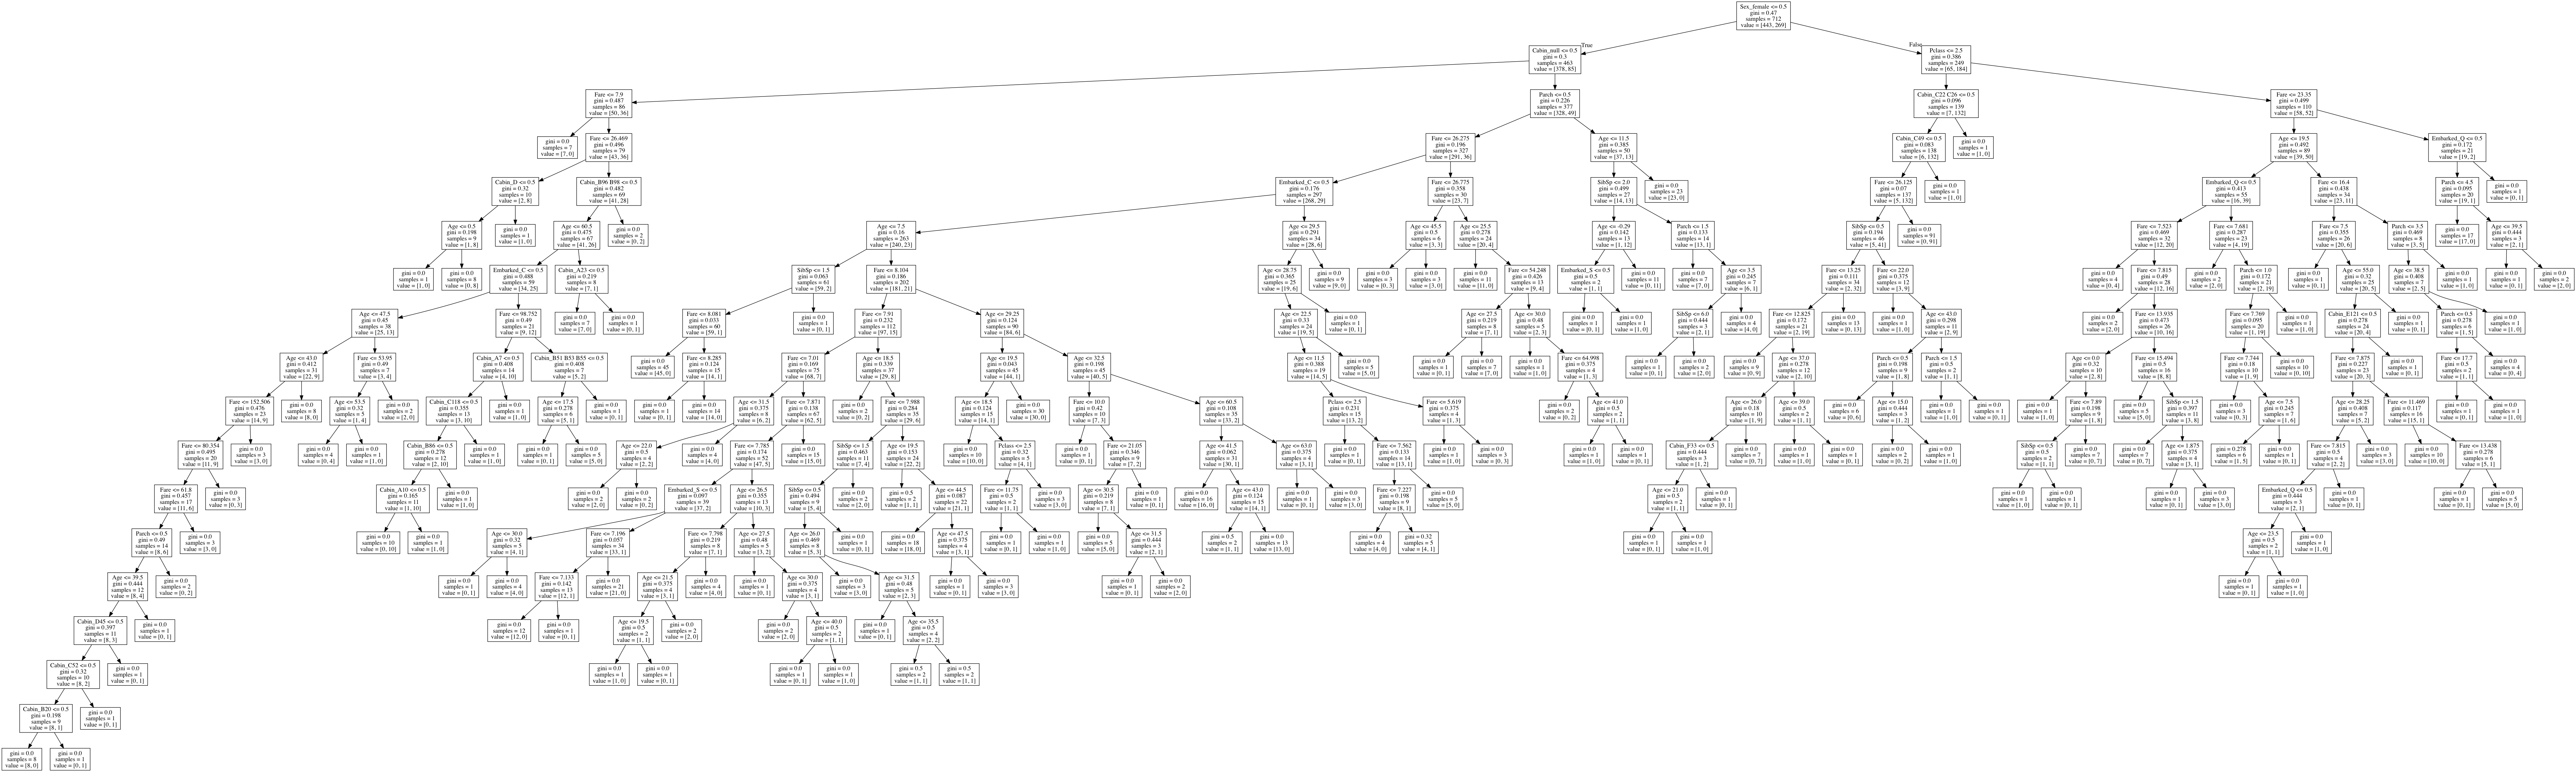

In [4]:
Image("media/all-features-tree.png")

With a training dataframe that looks like this:

In [5]:
X_train.head()

Pclass   Age  SibSp  Parch     Fare  PassengerId_1.0  PassengerId_2.0  \
301       3  -1.0      2      0  23.2500                0                0   
309       1  30.0      0      0  56.9292                0                0   
516       2  34.0      0      0  10.5000                0                0   
120       2  21.0      2      0  73.5000                0                0   
570       2  62.0      0      0  10.5000                0                0   

     PassengerId_3.0  PassengerId_4.0  PassengerId_5.0  ...  Cabin_F4  \
301                0                0                0  ...         0   
309                0                0                0  ...         0   
516                0                0                0  ...         0   
120                0                0                0  ...         0   
570                0                0                0  ...         0   

     Cabin_G6  Cabin_T  Cabin_null  Cabin_nan  Embarked_C  Embarked_Q  \
301         0        0           1          0           0           1   
309         0        0           0          0           1           0   
516         0        0           0          0           0           0   
120         0        0           1          0           0           0   
570         0        0           1          0           0           0   

     Embarked_S  Embarked_null  Embarked_nan  
301           0              0             0  
309           0              0             0  
516           1              0             0  
120           1              0             0  
570           1              0             0  

[5 rows x 2628 columns]

If we make a submission to kaggle, we end up with the following accuracy score:

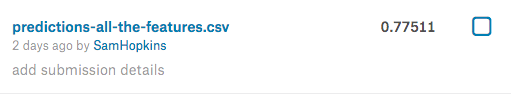

In [6]:
Image('media/all-features-kaggle-submission.png', width=800)

# Is this okay?

We have a X_train (and thus a model) that has a gazallion features. We have a decision tree that goes a million levels deep.

# NO! This is NOT OKAY!

Why not? Well for one thing, once we have created the dummies (as we should with categorical features) we end up with way more features than observations!

If you take this model to a responsible data scientist and claim that you are ready to put it into production, you will be laughed out of the room.


## Should we use a feature just because you can?

NO! Using a feature in your model just because you can has the potential to create all kinds of unknown scenarios, one of the worst is overfitting on a uninformative features.

Let's zoom in on one part of this monster decision tree that we have created and take a look at the bottom-right leaf node that contains a prediction:

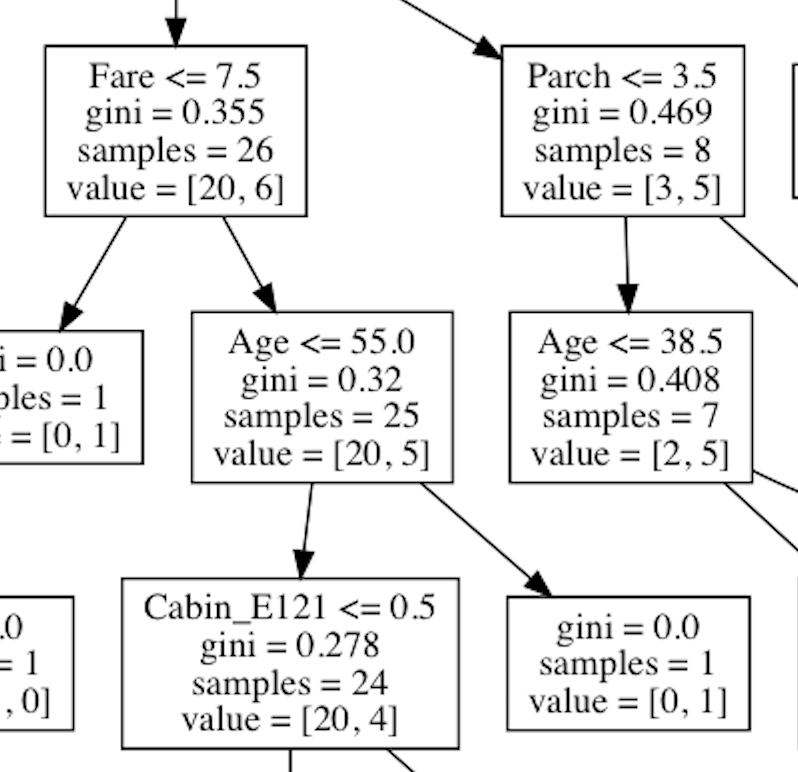

In [7]:
Image('media/overfit-zoom-in.png')

There is actually a split on whether the following conditions:

1. You are Male
1. Your Pclass is > 2.5
1. Your Fare is in between 7.5 and 16.4
1. Your age is between 19 and 55

There is exactly one single observation that fits this perscription. Furthermore, this is only about halfway down the tree which means that you can easily find many more nodes that contain only a single sample and have even more convoluted splits.

This is a severely overfit model and part of the reason was we decided to use all features available just because we can. 

# Okay, so let's actually select some features

The first thing that we can do is to find the low-hanging fruit with a little bit of Single Factor Analysis.

A couple of good heuristics is to look for categorical features that contain all unique values. Let's create a new series whose only job is to count the number of unique values (a.k.a categories) for each categorical value:

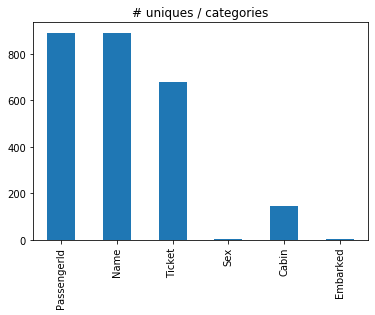

In [8]:
df.loc[:, categoricals].nunique().plot(kind='bar', title='# uniques / categories');

Now we have a bit of a starting point! We can combine our human brain to look at a few of these features that stand out while at the same time considering another of our important questions:

# Are all features informative?

Another way to ask this is: can all features be learned from and have predictive power that machine learning is able to leverage? Let's consider a few of the ones that have a high number of uniques.

## Name

There is one name for each person. If there is a single category for each and every individual then there's literally no way that a classifier can group observations! Imagine you have a decision tree that asks "is your name Sam Hopkins? If so, you will die!". It's totally silly to include something like Name in a predictive model.

## PassengerId

Same situation as Name. Usually datasets will contain a unique identifier to assign entities in datasets and this identifier does not mean anything at all when it comes to prediction.

# Kill them with fire!

Let's drop these two features and see we do now.

In [9]:
drop_columns = [
    'PassengerId',
    'Name'
]
# notice that we are using a new parameter in train_and_test called
# drop_columns which does exactly what it's name suggests!
X_train, train_df, clf = train_and_test(drop_columns=drop_columns)
X_preds = produce_test_predictions(train_df, clf, drop_columns=drop_columns)
X_preds.to_csv('data/predictions-no-name-or-passid.csv', index=False)
train_df.shape

X_test accuracy 0.776536312849162
X_train shape: (712, 844)


(891, 10)

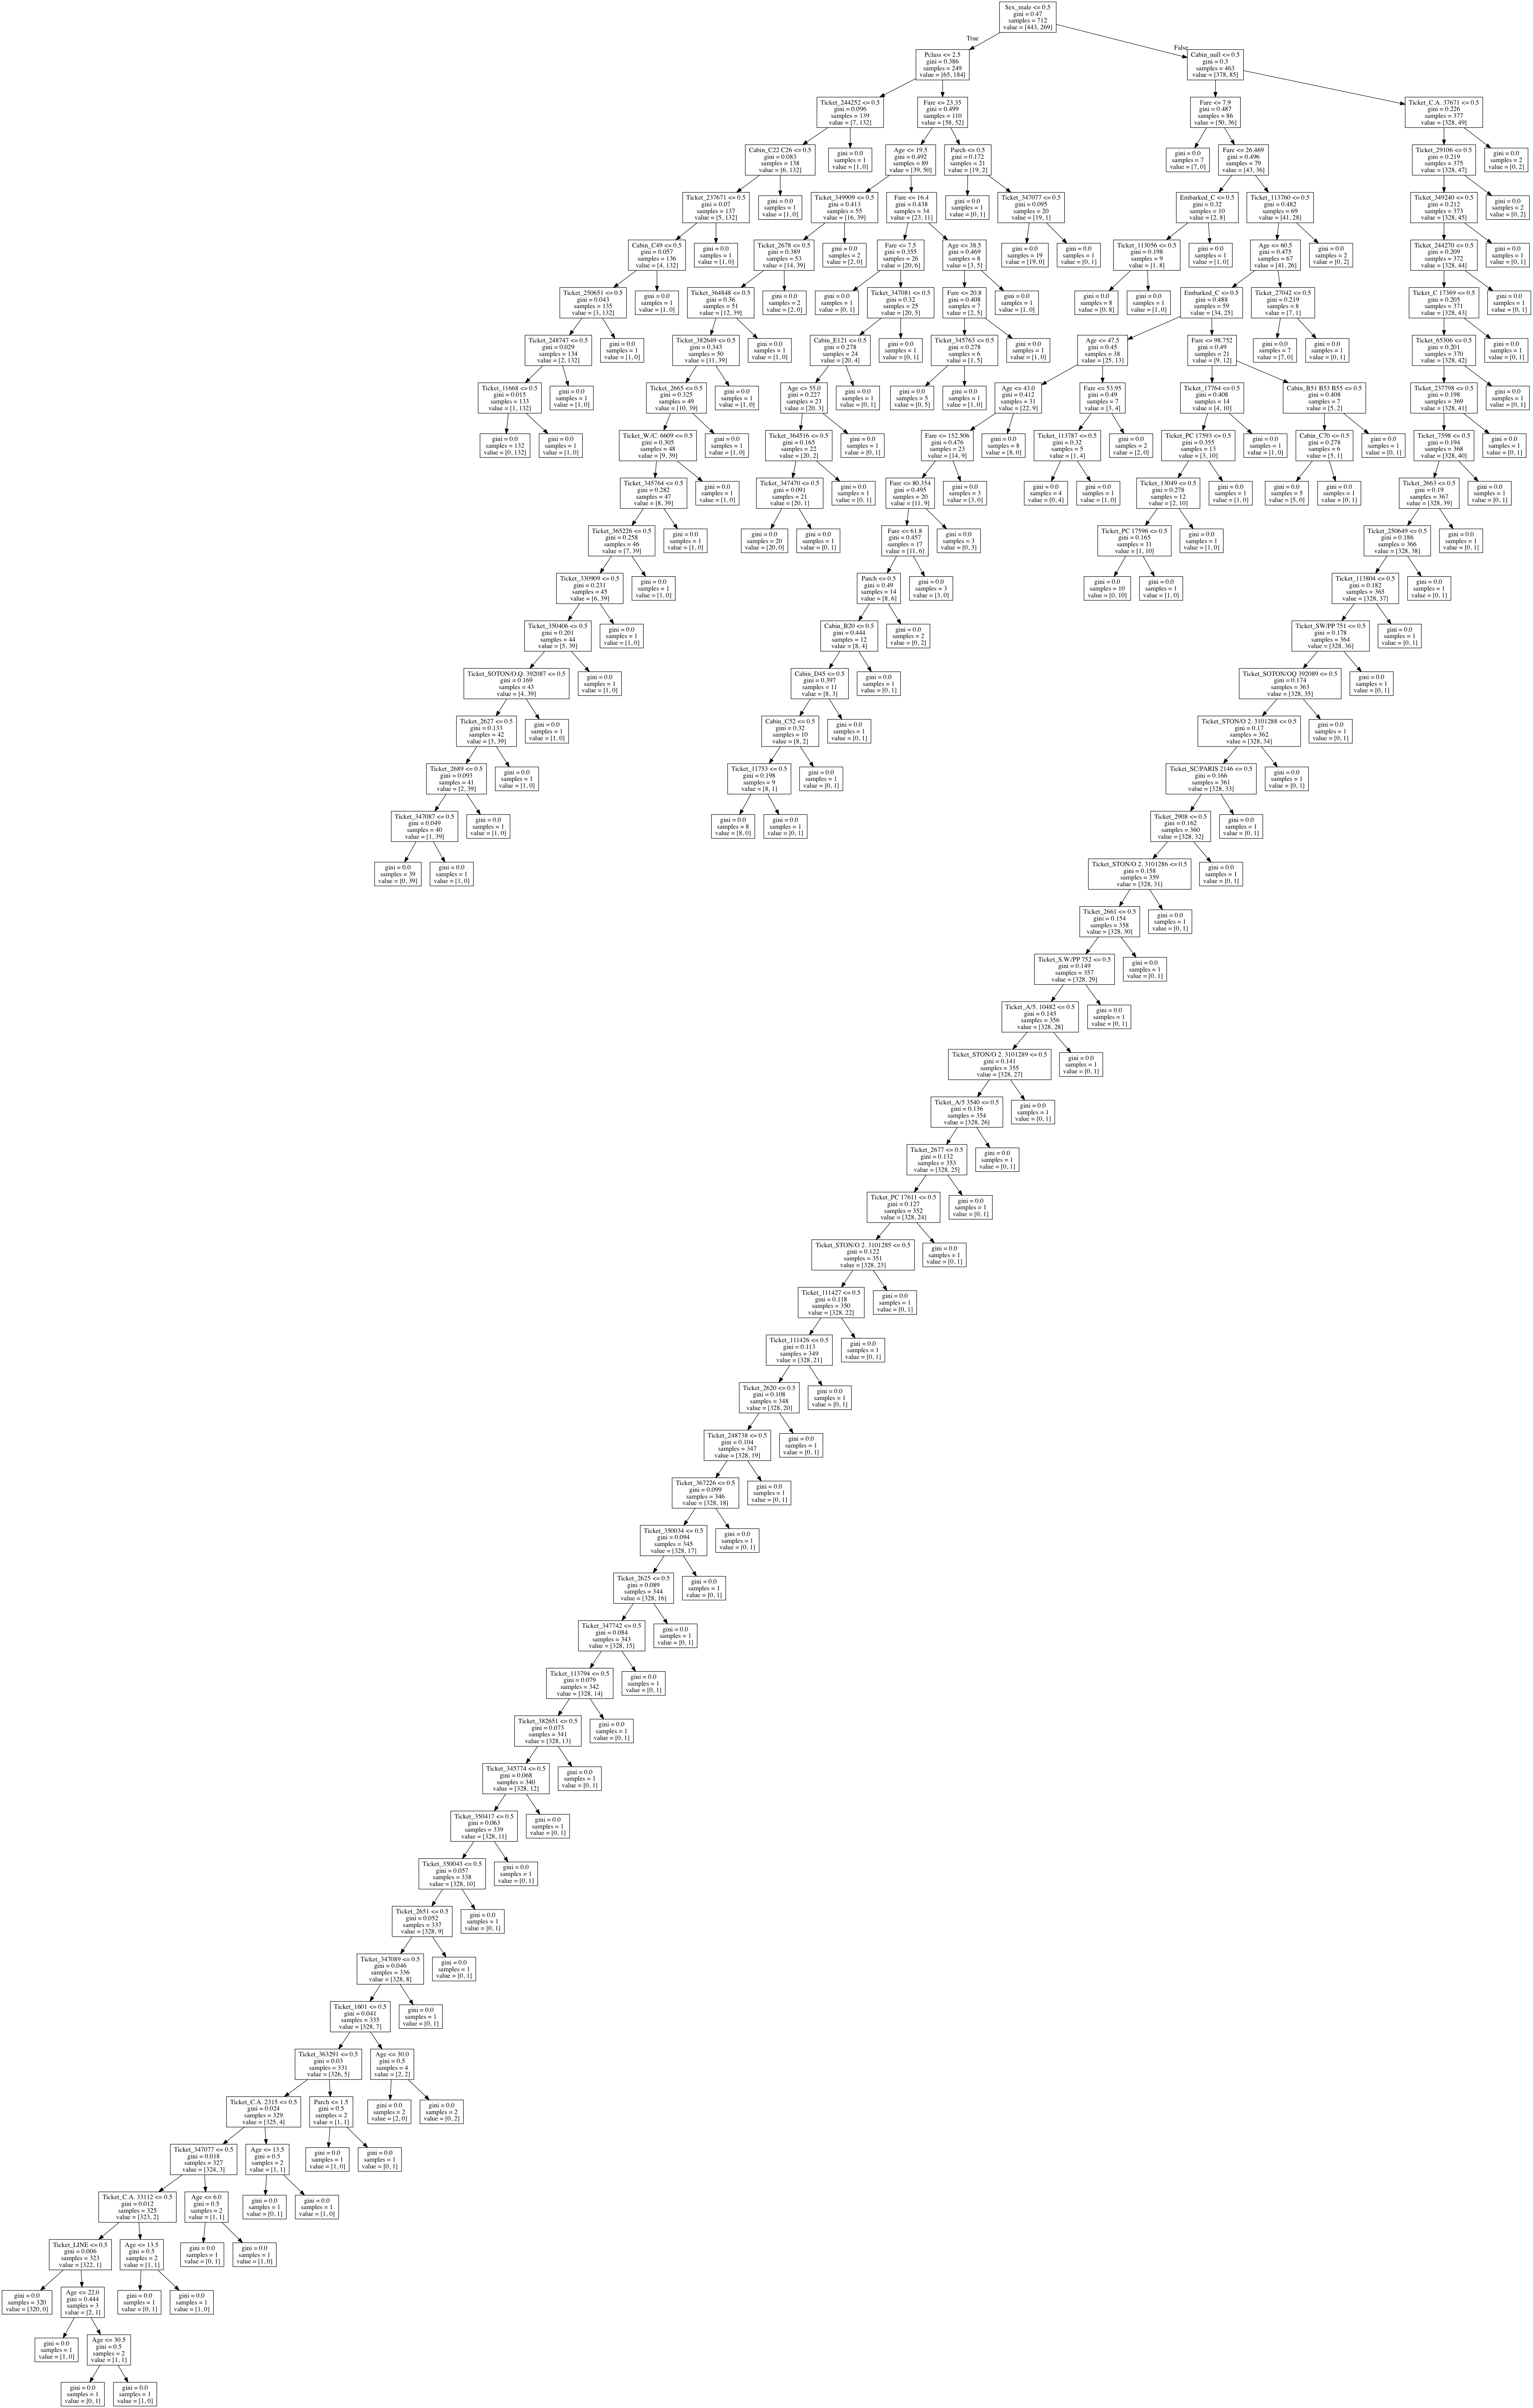

In [10]:
Image('./media/no-name-passid-tree.png')

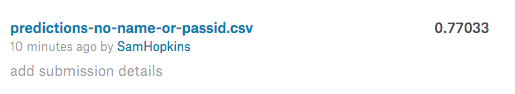

In [11]:
Image('media/no-name-passid-kaggle-submission.png', width=800)

# Improvement!

Okay we are starting to move in the right direction now. Although still very complex, our tree is much less complex than it was before and our predictive power stayed the same (a decrease in 0.005 doesn't mean anything in the real world, only kaggle). We still have 844 features though and if we revisit the chart that contained the number of uniques, we will be reminded why:

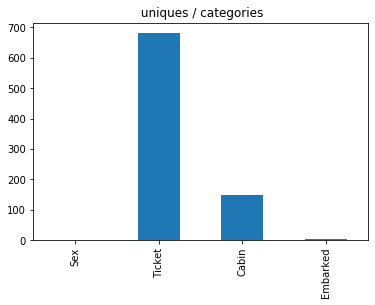

In [12]:
# Get all of the categorical that we have left and plot the number of uniques
# for each of them. It's essential the same as before but a bit more compact.
cols = train_df.columns.intersection(categoricals)
train_df.loc[:, cols].nunique().plot(kind='bar',  title=' uniques / categories');


And if we zoom into our tree a bit more we can see where most of the splits are being done on the ticket number:

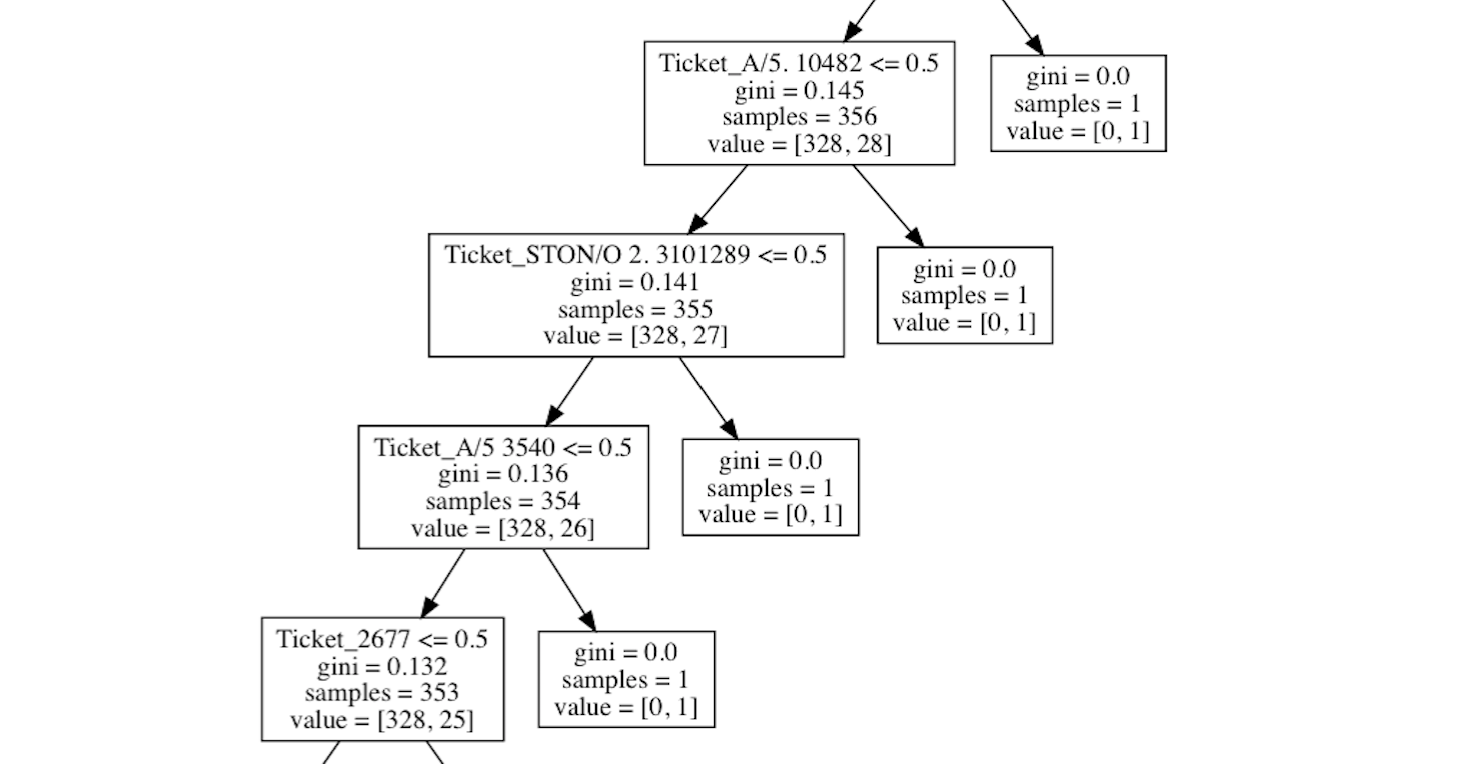

In [13]:
Image('media/no-name-passid-zoom-tree.png')

So now let's do a bit more Single Factor Analysis on this feature to see what kinds of information it actually has using the `value_counts()` function which is one of the most useful!

In [14]:
df.Ticket.value_counts().describe()

count    681.000000
mean       1.308370
std        0.792652
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        7.000000
Name: Ticket, dtype: float64

Alright now it looks like we've got the VAST majority tickets being assigned to only one person. Let's look at the first 10 value counts

In [15]:
df.Ticket.value_counts()[0:10]

347082          7
1601            7
CA. 2343        7
347088          6
CA 2144         6
3101295         6
S.O.C. 14879    5
382652          5
19950           4
347077          4
Name: Ticket, dtype: int64

So now let's take a look at the observations that have the `CA. 2343` ticket number to see if there is anything that might be justifyable to keep because it does an actual meaningful grouping of people.

In [16]:
df[df.Ticket == 'CA. 2343']

PassengerId  Survived  Pclass                               Name     Sex  \
159          160         0       3         Sage, Master. Thomas Henry    male   
180          181         0       3       Sage, Miss. Constance Gladys  female   
201          202         0       3                Sage, Mr. Frederick    male   
324          325         0       3           Sage, Mr. George John Jr    male   
792          793         0       3            Sage, Miss. Stella Anna  female   
846          847         0       3           Sage, Mr. Douglas Bullen    male   
863          864         0       3  Sage, Miss. Dorothy Edith "Dolly"  female   

     Age  SibSp  Parch    Ticket   Fare Cabin Embarked  
159  NaN      8      2  CA. 2343  69.55   NaN        S  
180  NaN      8      2  CA. 2343  69.55   NaN        S  
201  NaN      8      2  CA. 2343  69.55   NaN        S  
324  NaN      8      2  CA. 2343  69.55   NaN        S  
792  NaN      8      2  CA. 2343  69.55   NaN        S  
846  NaN      8      2  CA. 2343  69.55   NaN        S  
863  NaN      8      2  CA. 2343  69.55   NaN        S

In [17]:
df[df.Ticket == '347082']

PassengerId  Survived  Pclass  \
13            14         0       3   
119          120         0       3   
541          542         0       3   
542          543         0       3   
610          611         0       3   
813          814         0       3   
850          851         0       3   

                                                  Name     Sex   Age  SibSp  \
13                         Andersson, Mr. Anders Johan    male  39.0      1   
119                  Andersson, Miss. Ellis Anna Maria  female   2.0      4   
541               Andersson, Miss. Ingeborg Constanzia  female   9.0      4   
542                  Andersson, Miss. Sigrid Elisabeth  female  11.0      4   
610  Andersson, Mrs. Anders Johan (Alfrida Konstant...  female  39.0      1   
813                 Andersson, Miss. Ebba Iris Alfrida  female   6.0      4   
850            Andersson, Master. Sigvard Harald Elias    male   4.0      4   

     Parch  Ticket    Fare Cabin Embarked  
13       5  347082  31.275   NaN        S  
119      2  347082  31.275   NaN        S  
541      2  347082  31.275   NaN        S  
542      2  347082  31.275   NaN        S  
610      5  347082  31.275   NaN        S  
813      2  347082  31.275   NaN        S  
850      2  347082  31.275   NaN        S

In [18]:
df[df.Ticket == '382652']

PassengerId  Survived  Pclass                                  Name  \
16            17         0       3                  Rice, Master. Eugene   
171          172         0       3                  Rice, Master. Arthur   
278          279         0       3                    Rice, Master. Eric   
787          788         0       3             Rice, Master. George Hugh   
885          886         0       3  Rice, Mrs. William (Margaret Norton)   

        Sex   Age  SibSp  Parch  Ticket    Fare Cabin Embarked  
16     male   2.0      4      1  382652  29.125   NaN        Q  
171    male   4.0      4      1  382652  29.125   NaN        Q  
278    male   7.0      4      1  382652  29.125   NaN        Q  
787    male   8.0      4      1  382652  29.125   NaN        Q  
885  female  39.0      0      5  382652  29.125   NaN        Q

Now this is some hardcore analysis - actually looking at the data grouped by a single features. This is something that is important to do every once in a while when you get stuck. However, at a cursory glance this isn't really showing us much so we should probaby take another approach to understand if we should use this feature or not.

### How much does a model rely on a feature?

One type feature selection is that of looking at how important a feature is to a model that you have already trained. This type of approach generally means that you are going to train a model with more features than you actually think you need and then look at the fitted models' attributes to see how much the model relied on it.

#### feature_importances_ for tree-based models

One really great way to do this is by using the [feature_importances_](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_) of your classifier. This is a very useful attribute that you can use to understand how much the tree-based classifiers rely on each feature when making predictions.

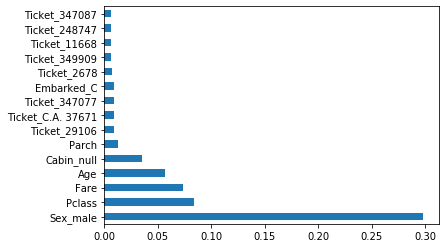

In [19]:
pd.Series(clf.feature_importances_, index=X_train.columns).nlargest(15).plot.barh();

#### coef_ for linear models models

Somewhat analogous to the `feature_importances` of a tree-based classifier is the [coef_](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) attribute that can be found on linear models. Note that in order to use this you must first scale your features!

X_test accuracy 0.8044692737430168
X_train shape: (712, 9)


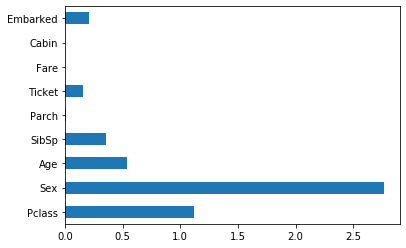

In [20]:
drop_columns = [
    'PassengerId',
    'Name'
]
X_train, train_df, clf_logit = train_and_test_logit(drop_columns=drop_columns)
pd.Series(abs(clf_logit.coef_[0, :]), index=X_train.columns).plot.barh();

What we can see from this is that in the grand scheme of things, the tickets don't really seem to play a huge rule. Furthermore in our battle against complexity, we know that it's adding a lot of it because our feature space blows up when we use it. So let's get rid of it and see how things behave.

In [21]:
drop_columns = [
    'PassengerId',
    'Name',
    'Ticket'
]

X_train, train_df, clf = train_and_test(drop_columns=drop_columns)
X_preds = produce_test_predictions(train_df, clf, drop_columns=drop_columns)
X_preds.to_csv('data/predictions-no-name-passid-ticket.csv', index=False)

X_test accuracy 0.7206703910614525
X_train shape: (712, 162)


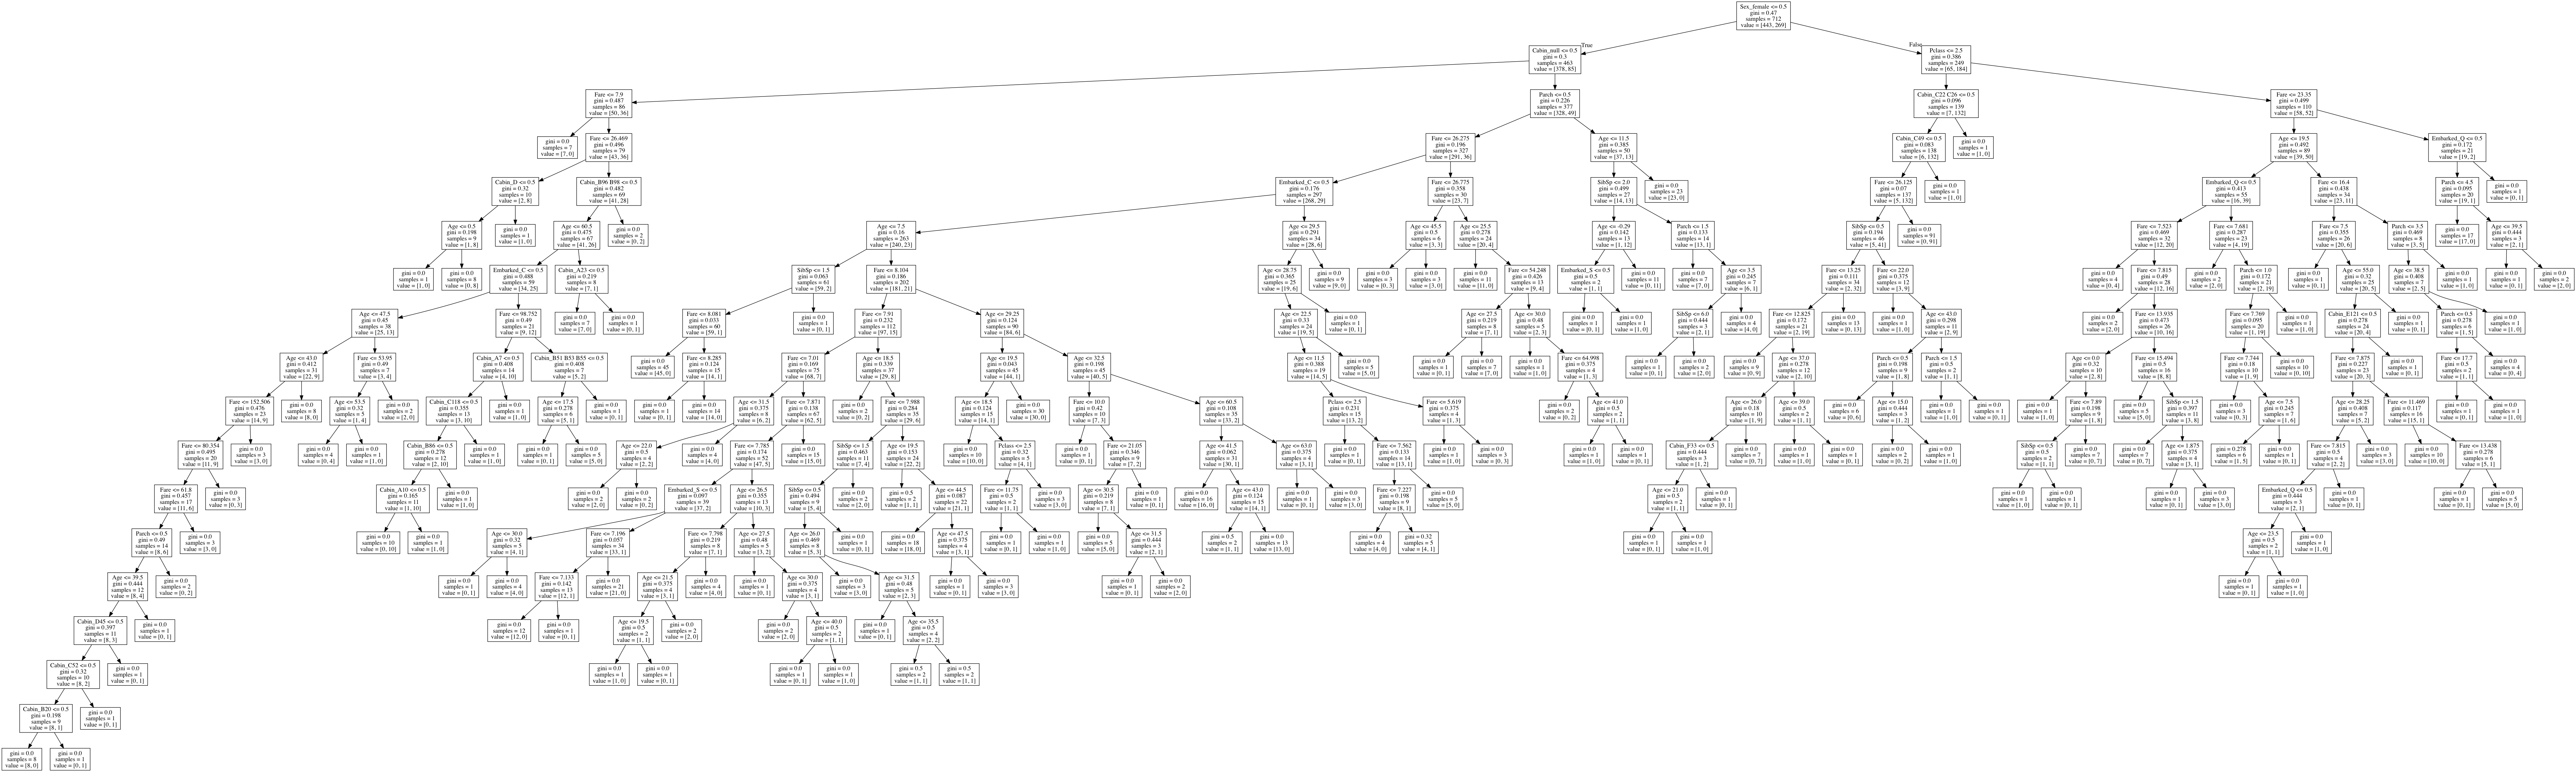

In [22]:
Image('media/no-name-passid-ticket-tree.png')

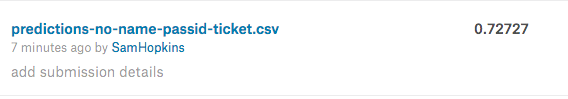

In [23]:
Image('media/kaggle-submission-no-name-passid-ticket.png', width=800)

# Less features, still crazy tree!

Although we now have many less features, our tree is still very heavy-duty in terms of complexity. Our classifier is definitely closer to being auditable because of the decrease in the number of features, but the tree still seems to have found a way to make itself crazy deep.

## Important Question - How many features is too many?

Many professionals in the industry use the rule of thumb that the number of features you use should in a classifier not exceed 20% the number of observations. So in this respect, we've come a long way since the beginning! We started off with more than 2,000 features in a dataset with 891 observations in the training set which is not cool. We've now arrived at 162/891=18% so at least we are now within acceptedable heuristic number.

## About that performance...

However we've now hit a decrease in the accuracy score (~77 to ~73) which is non-trivial. At this point you may be tempted to bring back the Ticket feature in an effort to regain that lost performance but don't! It's not worth it! Instead, try to work with what you've got and take an approach to tuning the model a bit to help it make better use of the features that it has. Let's do this with the max-depth hyperperameter of the DecisionTreeClassifier. What this will do is help the decision tree resist the temptation to overfit on features that might not be particularly useful.

In [24]:
drop_columns = [
    'PassengerId',
    'Name',
    'Ticket'
]

X_train, train_df, clf = train_and_test(drop_columns=drop_columns, max_depth=5)
X_preds = produce_test_predictions(train_df, clf, drop_columns=drop_columns)
X_preds.to_csv('data/predictions-no-name-passid-ticket-depth-5.csv', index=False)

X_test accuracy 0.7653631284916201
X_train shape: (712, 162)


Hooray! On our test set, the improvement is back up! Let's make a submission and see how that goes!

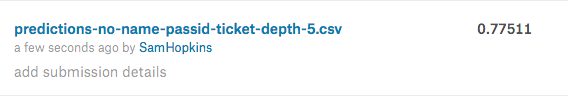

In [25]:
Image('media/kaggle-submission-no-name-passid-ticket-depth-5.png', width=800)

We're back in business in terms of performance, baby! And we've got a much less offensive tree! Whew, good thing we didn't succomb to the temptation of adding more features for a quick win on a kaggle metric!

Furthermore, our tree is starting to look a lot better. Even though there's still a few little bits and bots in there that don't inspire confidence, at least we can take it all in one glance now.

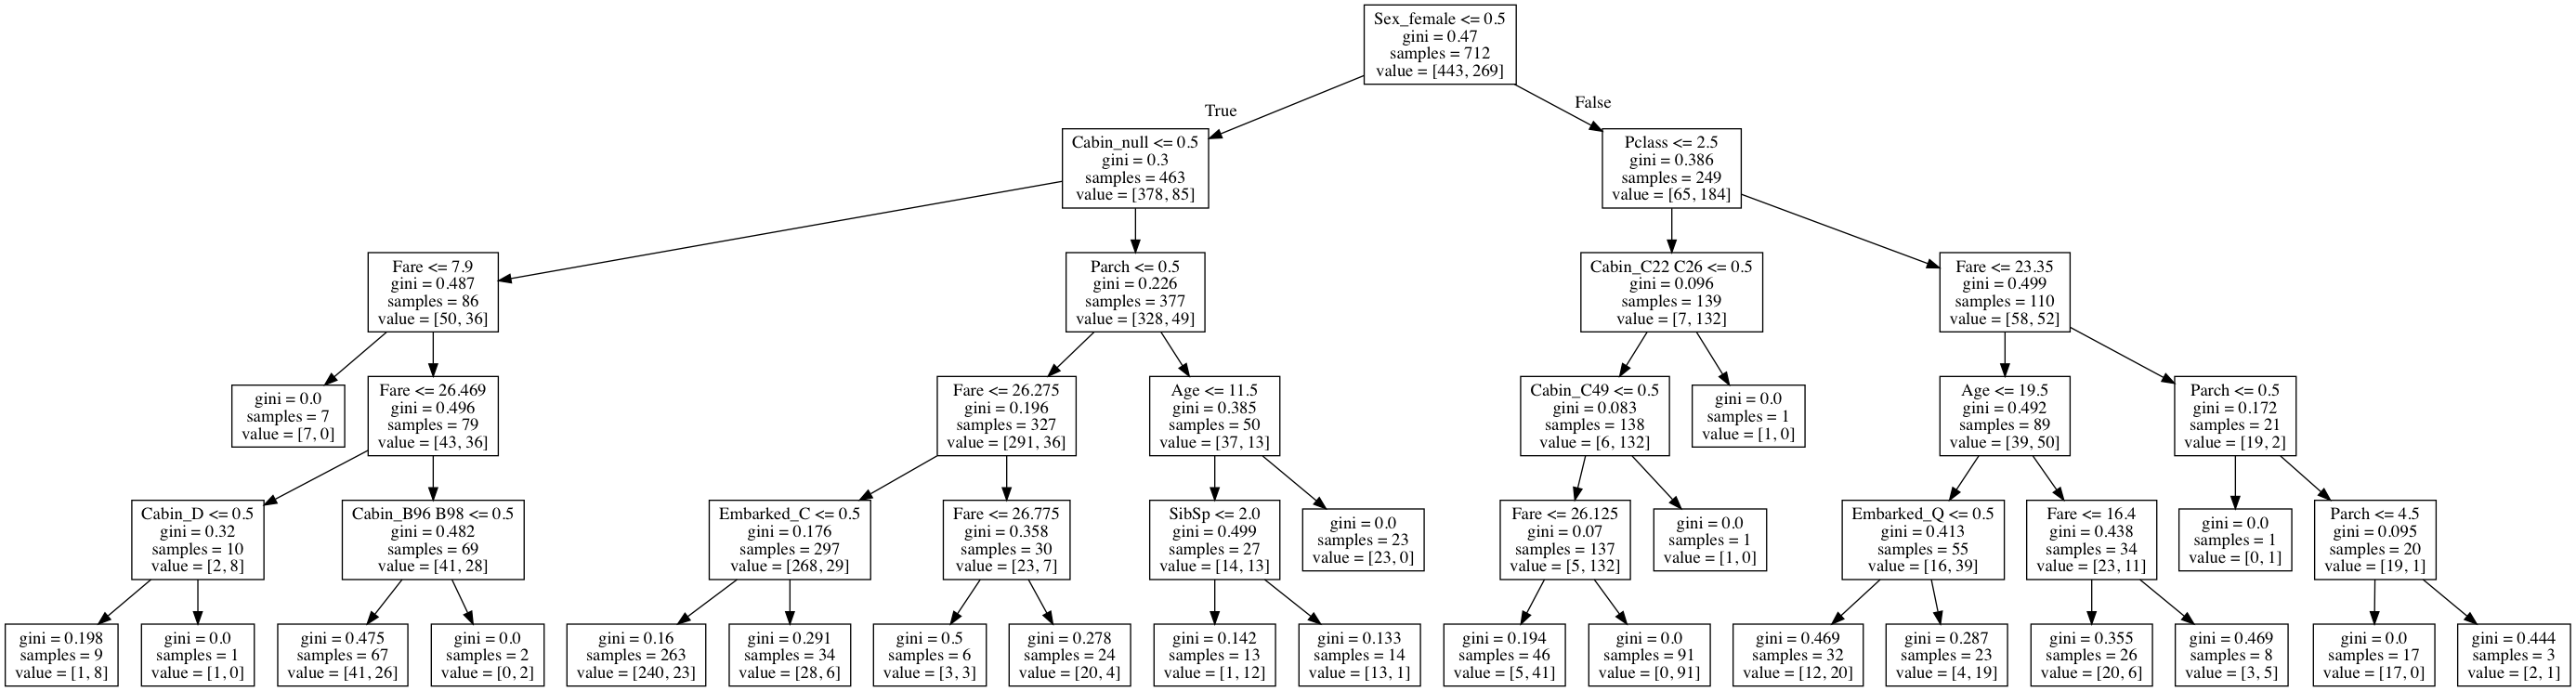

In [26]:
Image('media/no-name-passid-ticket-depth-5-tree.png')

# Why not keep going?

In our battle against complexity, why not try to continue removing features to understand if we can rack up another win for simplicity?

Let's consult our feature importances again to pick the features we want to keep rather than the ones that we want to get rid of. Let's be aggressive in this battle!

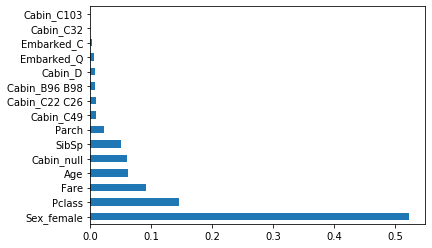

In [27]:
pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15).plot.barh();

In [28]:
drop_columns = [
    'PassengerId',
    'Name',
    'Ticket',
    'Cabin',
    'Embarked',
    'Parch',
    'SibSp'
]

X_train, train_df, clf = train_and_test(drop_columns=drop_columns, max_depth=5)
X_preds = produce_test_predictions(train_df, clf, drop_columns=drop_columns)
X_preds.to_csv('data/predictions-super-simple.csv', index=False)

X_test accuracy 0.7653631284916201
X_train shape: (712, 6)


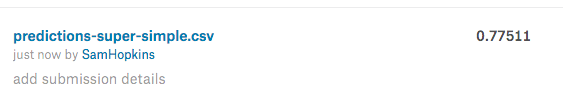

In [29]:
Image('media/kaggle-submission-super-simple.png', width=800)

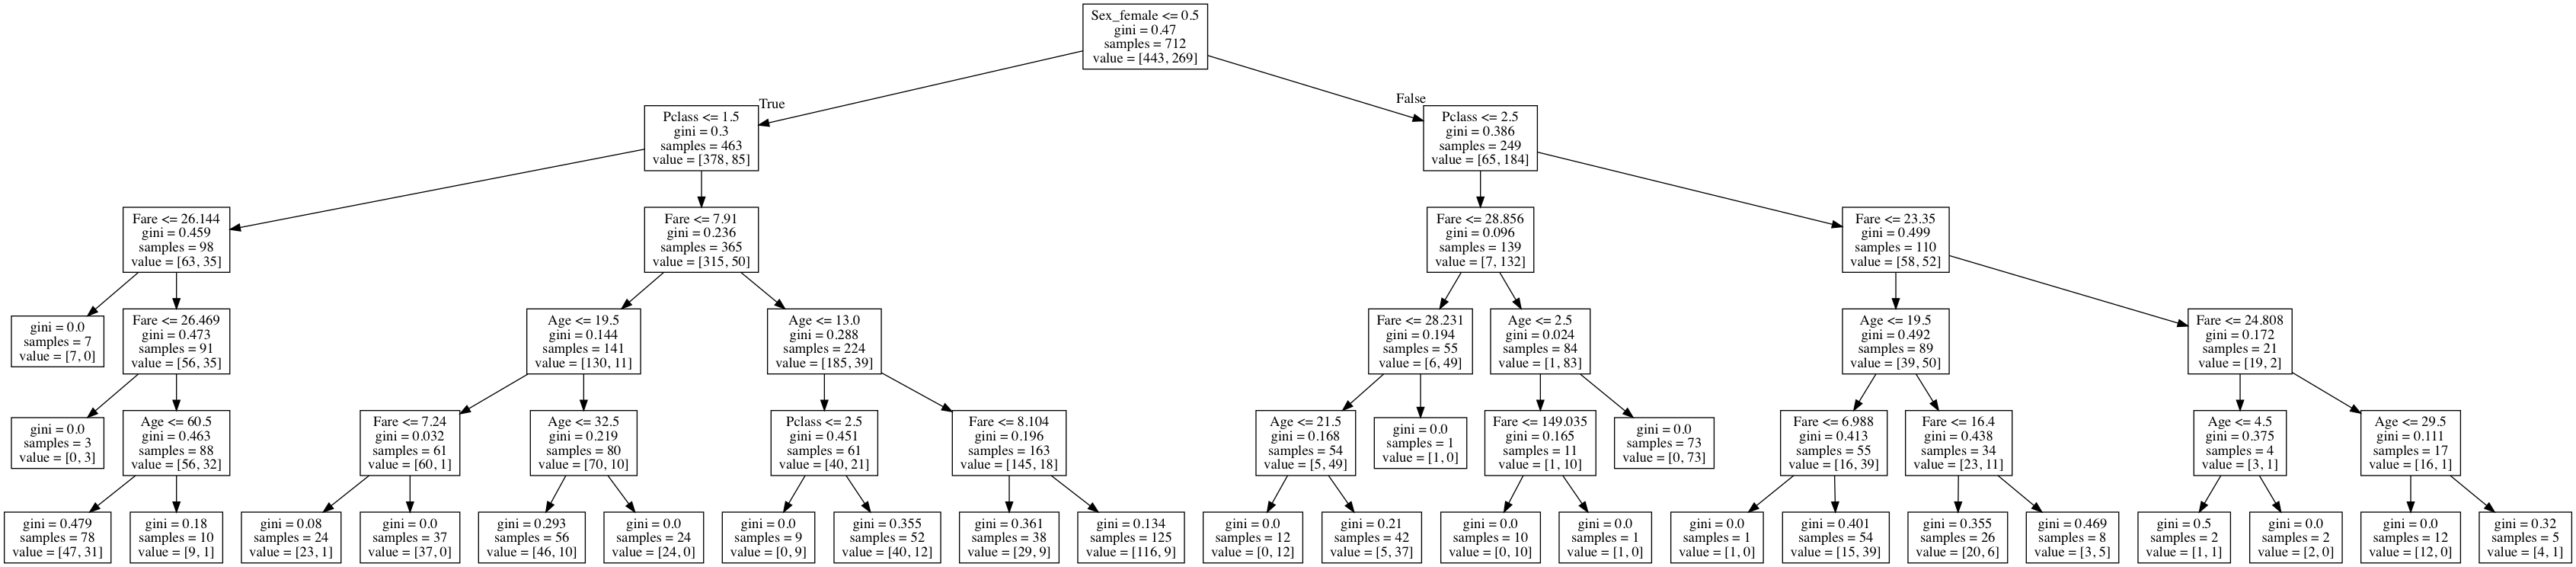

In [30]:
Image('media/super-simple-tree.png')

In [31]:
# and we only had to create a few dummies!
X_train.columns

Index(['Pclass', 'Age', 'Fare', 'Sex_female', 'Sex_male', 'Sex_nan'], dtype='object')

Man, this is a HUGE win! Our performance is literally the same as it was when we were working with a massively complex dataset with too many features as well as an absolutely obnoxious tree structure.

And when we take a look at the feature importances, no headache! It just makes sense!

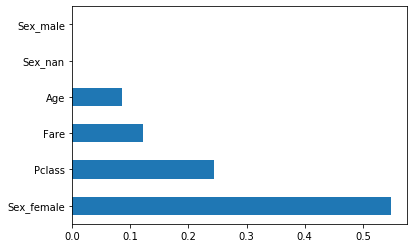

In [32]:
pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False).plot.barh();

## More excellent tools for your feature selection toolbox

It's great that we've gone through some very detailed single factor analysis and really understood
why or why not to include some features. However, like many data science things that are worth
doing more than once, there are some excellent high-level tools to cut down on the amount of time
and code that you'll need to achieve your data science goals.

#### Warning

Note that none of these tools are or should be considered replacements for actually looking at your data and developing a real live understanding of them.

### sklearn.feature_selection.SelectKBest

The first of these tools is the [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) that can be used in conjunction with other functions that are generally found in the `sklearn.feature_selection` package.

When using `SelectKBest` you will need to make a couple of choices. The most important of these, because of the 
way it works, you'll need to decide what function you'll want to use to evaluate features. When deciding this, 
you can refer to the [documentation here](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) that tells you what type of prediction problem you can use each of the methods for.

After reading the documentation we discover that, because we are working on a classification problem, we have
the following options: `mutual_info_classif`, `chi2`, `f_classif`. Let's have a go at each one of them and see
what they produce.

#### Warning

Going over each of these methods is out of the scope of this LU and you should definitely take the time to understand them before using.

In [33]:
# Let's encode the categoricals into codes because the methods that we are using
# will fail if there are any nulls or non-numerics
_, X, y = encode_categoricals()

# Now we'll set the number of features that we want to select to be 4
k = 4

# And let us define a convenience function because we want to do the
# exact same thing 3 times with slightly different params

def select_k_best(method):
    skb = SelectKBest(method, k=k)
    skb.fit(X, y)
    if method is not mutual_info_classif:
        p_values = skb.pvalues_.round(4)
    else:
        p_values = None
    result = pd.DataFrame({
        'column': X.columns, 
        'p_values': p_values, 
        'scores': skb.scores_,
        'selected': skb.get_support()
    }).sort_values(by='scores', ascending=False)
    return result

Okay, now that we're set up, let's see what features each of these methods select

In [34]:
select_k_best(chi2)

column  p_values       scores  selected
8          Fare    0.0000  4518.319091      True
7        Ticket    0.0000  2871.655466      True
9         Cabin    0.0000   573.925858      True
2          Name    0.0000   435.568915      True
3           Sex    0.0000    92.702447     False
1        Pclass    0.0000    30.873699     False
4           Age    0.0000    24.687926     False
6         Parch    0.0015    10.097499     False
10     Embarked    0.0018     9.755456     False
0   PassengerId    0.0684     3.320379     False
5         SibSp    0.1081     2.581865     False

In [35]:
select_k_best(mutual_info_classif)

column p_values    scores  selected
3           Sex     None  0.149858      True
8          Fare     None  0.120286      True
7        Ticket     None  0.117609      True
1        Pclass     None  0.059834      True
10     Embarked     None  0.039915     False
9         Cabin     None  0.027632     False
0   PassengerId     None  0.019706     False
4           Age     None  0.018985     False
5         SibSp     None  0.012000     False
2          Name     None  0.004138     False
6         Parch     None  0.000000     False

In [36]:
select_k_best(f_classif)

column  p_values      scores  selected
3           Sex    0.0000  372.405724      True
1        Pclass    0.0000  115.031272      True
8          Fare    0.0000   63.030764      True
9         Cabin    0.0000   61.769420      True
7        Ticket    0.0000   24.740828     False
10     Embarked    0.0000   24.422821     False
6         Parch    0.0148    5.963464     False
4           Age    0.0372    4.353516     False
2          Name    0.0871    2.932903     False
5         SibSp    0.2922    1.110572     False
0   PassengerId    0.8814    0.022285     False

Well this is interesting and is a great example of what happens if you were to just blindly use a methods without taking the time to understand how they work. It's interesting to see how all of them selected `Fare` and it's equally interesting to see some of the other features that have been selected.

The statistical tests (`chi2` and `f_classif`) include a `p_value` attribute that gives you the direct p-values according to the hypothesis that they are testing. The `mutual_info_classif` is not a statistical test so the output of the function is used directly as the score.

It's outside the scope of this LU to go into depth how each of these methods work, especially since there are so many of them available for all of your different models. Before choosing which to use, you should have a cursory understanding of your dataset and have a strong justification for using it BEFORE you apply the method and not after.

### DataFrame.corr

A VERY simple and useful method that you already know about is using straight pandas and looking at correlation. This is a special case where you can just look at the correlation with the target variable as we are doing here. From it you can see that some of our intuitions about the more informative features. 

In [37]:
df, _, _ = encode_categoricals()
corrs = df.corr()
# See all pairwise correlations
corrs.head()

PassengerId  Survived    Pclass      Name       Sex       Age  \
PassengerId     1.000000 -0.005007 -0.035144 -0.038559  0.042939  0.033207   
Survived       -0.005007  1.000000 -0.338481 -0.057343 -0.543351 -0.069809   
Pclass         -0.035144 -0.338481  1.000000  0.052831  0.131900 -0.331339   
Name           -0.038559 -0.057343  0.052831  1.000000  0.020314  0.057466   
Sex             0.042939 -0.543351  0.131900  0.020314  1.000000  0.084153   

                SibSp     Parch    Ticket      Fare     Cabin  Embarked  
PassengerId -0.057527 -0.001652 -0.056554  0.012658 -0.035077  0.013083  
Survived    -0.035322  0.081629 -0.164549  0.257307 -0.254888 -0.163517  
Pclass       0.083081  0.018443  0.319869 -0.549500  0.684121  0.157112  
Name        -0.017230 -0.049105  0.047348 -0.049173  0.061959 -0.004557  
Sex         -0.114631 -0.245489  0.059372 -0.182333  0.096681  0.104057

In [38]:
# now take the correlations with the target variable
corrs_with_target = corrs['Survived']
corrs_with_target

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Name          -0.057343
Sex           -0.543351
Age           -0.069809
SibSp         -0.035322
Parch          0.081629
Ticket        -0.164549
Fare           0.257307
Cabin         -0.254888
Embarked      -0.163517
Name: Survived, dtype: float64

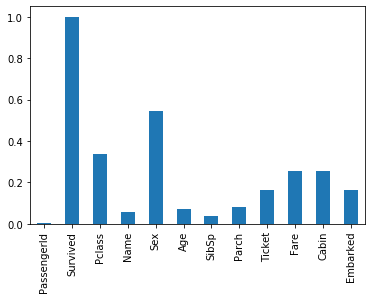

In [51]:
# take the absolute values because for the purposes of feature selection we are
# usually interested in it regardless of whether the correlation is positive
# or negative
corrs_with_target_abs = corrs_with_target.abs()

# and plot it so that we get an easy-to-compare ranking
corrs_with_target_abs.plot(kind='bar');

### sklearn.feature_selection.SelectFromModel

One shortcut to using the `coef_` and `feature_importances_` directly is to use the [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) class. Using this, you can take an already fitted model and give it a threshold or a max number of features that you want and let it do the work of accessing the correct attribute for you.

To demonstrate how it works, let's fit a few different modelt and then see how we can use `SelectFromModel` in the exact same way to select the the top 4 features according to the model.

In [40]:
def select_from_model(clf, X_train):
    sfm = SelectFromModel(clf, prefit=True, max_features=4)
    selected_features = X_train.columns[sfm.get_support()]
    return list(selected_features)

In [41]:
X_train, _, clf_tree = train_and_test(drop_columns=[], encode_cats=True)
select_from_model(clf_tree, X_train)

X_test accuracy 0.770949720670391
X_train shape: (712, 11)


['Name', 'Sex', 'Age', 'Ticket']

In [42]:
X_train, train_df, clf_logit = train_and_test_logit(drop_columns=[])
select_from_model(clf_logit, X_train)

X_test accuracy 0.7988826815642458
X_train shape: (712, 11)


/Users/sam/anaconda3/envs/slu16/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['Pclass', 'Sex', 'Age']

# We're good, right? Time for a beer?

Not quite! What we've been doing so far is looking creating different models with different attributes, looking at the tree structures they create (specific to decision trees), and dropping features to see if it affects our Kaggle score. While this is good to gain an intuition of the space and to optimize our leaderboard status, we need to understand what we've been doing in a way that is not specific to decision trees and is quite fundamental to predictive modeling.


# Learning curves to the rescue!

As per the scikit [documentation page](http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve) on learning curves, they can help us understand a few things:


1. Whether the estimator suffers more from a variance error or a bias error
1. Find out how much we benefit from adding more training data


# Why do we care about these points?

Firstly, you need to understand where your model is in terms of the tradeoff between bias and variance. A classifier that is extremely overfit (high variance) can give us a false sense of security in terms of its performance and have dire consequences if put into production. You don't want to be the guy that claims your model is a perfect performer using cold hard numbers only to put it into production

Secondly, knowing how much training data you need in order for your classifier to converge in performance. Since data collection and training times are usually bottlenecks in doing machine learning, this is hugely important information that can have serious impact on business processes.


# Let's look at some learning curves

## Scenario number 1

First, let's look at the learning curve of the last model that we ended up with.

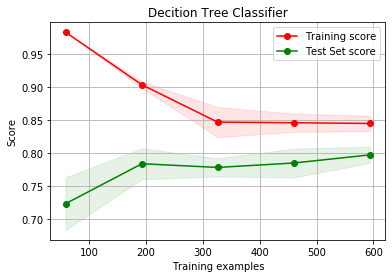

In [43]:
drop_columns = [
    'PassengerId',
    'Name',
    'Ticket',
    'Cabin',
    'Embarked',
    'Parch',
    'SibSp'
]
# Create X, y from the original dataset
_, X, y = read_and_get_dummies(drop_columns)
plot_learning_curve(DecisionTreeClassifier(random_state=1, max_depth=5), 'Decition Tree Classifier', X, y);

Alright, let's take a few conclusions from these learning curves

1. With a low number of samples, the classifier scores VERY high on the training set and has the lowest score on the test set. This makes some sense because it has so little training data that all it can do is build a classifier that predicts the training set and has no chance to generalize. This is very overfit because it doesn't have enough training data.
1. When we reach about 300 samples, we start to reach a steady state between the training and test score. That means that for this particular model on this particular dataset, it doesn't seem to benefit much from more data.
    - This is actually super important in case you have some business requirements around how much data you can reasonably collect for user experience or regulatory reasons for example.

This learning curve can be considered a healthy one. It overfits on a small amount of data and can't generalize which is expected but when you give it more data, the training and test scores start to converge though the training score is always higher.

## Scenario number 2

Now let's take a look at one of our more over fit models that we built today.

This is the scenario in which we experienced the performance drop on the Kaggle leaderboard from 77 down to 73 where we got rid of 3 columns (one being ticket) and didn't restrict the tree depth.

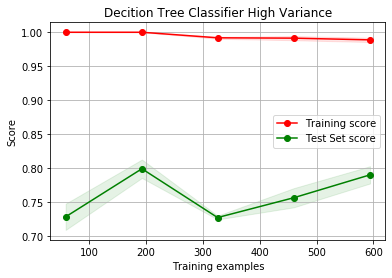

In [44]:
drop_columns = [
    'PassengerId',
    'Name',
    'Ticket'
]

_, X, y = read_and_get_dummies(drop_columns)

plot_learning_curve(
    X=X,
    y=y,
    estimator=DecisionTreeClassifier(random_state=1),
    title='Decition Tree Classifier High Variance',
);

Conclusions on this one:

1. Here is a model with VERY high variance - it is almost perfect at predicting the training set (a huge sign of overfitting)
1. The amount of training data doesn't seem to have any effect on the performance. It actually lowered the test set performance significantly when going from 200->300 samples while staying almost perfect on the test set.

This is a scarily overfitted model - don't be the data scientist that puts this model into production!

# How to use the scikit learning curve APIs

So when plotting learning curves, you should use the plot_learning_curve function that has been supplied here, but let's understand a bit more about how these plots are created by going one API level lower by using the scikit [learning_curve](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve) function directly.

In [45]:
# first you need your X and Y in the same way that you would need it 
# actually train a classifier because that's exactly what the
# learning_curve function actually does!
drop_columns = [
    'PassengerId',
    'Name',
    'Ticket'
]
_, X, y = read_and_get_dummies(drop_columns)

# now create your classifier
estimator = DecisionTreeClassifier(random_state=1, max_depth=5)

# here's where the magic happens! The learning curve function is going
# to take your classifier and your training data and subset the data
train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=3)

In [46]:
# 5 different training set sizes have been selected
# with the smallest being 59 and the largest being 594
# the remaining is used for testing
print('train set sizes', train_sizes)
print('test set sizes', X.shape[0] - train_sizes)

train set sizes [ 59 193 326 460 594]
test set sizes [832 698 565 431 297]


In [47]:
# each row corresponds to a training set size
# each column corresponds to a cross validation fold
# the first row is the highest because it corresponds
# the smallest training set which means that it's very
# easy for the classifier to overfit and have perfect
# test set predictions while as the test set grows it
# bcomes a bit mor difficult for this to happen.
train_scores

array([[0.96610169, 0.94915254, 0.94915254],
       [0.9119171 , 0.9015544 , 0.9015544 ],
       [0.88343558, 0.85889571, 0.85582822],
       [0.85217391, 0.84130435, 0.83695652],
       [0.87373737, 0.84680135, 0.84848485]])

In [48]:
# The test set scores where again, each row corresponds
# to a train / test set size and each column is a differet
# run with the same train / test sizes
test_scores

array([[0.72053872, 0.75757576, 0.74747475],
       [0.78451178, 0.81818182, 0.8013468 ],
       [0.79124579, 0.78451178, 0.79461279],
       [0.7979798 , 0.79461279, 0.78787879],
       [0.79461279, 0.81144781, 0.78787879]])

In [49]:
# Let's average the scores across each fold so that we can plot them
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

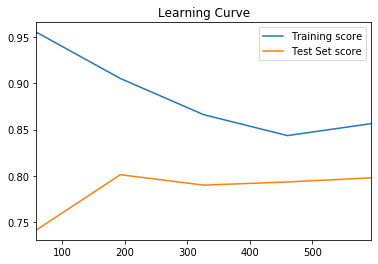

In [50]:
learning_curve_df = pd.DataFrame({
    'Training score': train_scores_mean,
    'Test Set score': test_scores_mean
}, index=train_sizes)

learning_curve_df.plot.line(title='Learning Curve')